In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
    !pip install -q -U tfx
    print("패키지 호환 에러는 무시해도 괜찮습니다.")
except Exception:
    pass

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Chapter 13. 텐서플로에서 데이터 적재와 전처리 하기

## 13.1 데이터 API

In [3]:
#간단히 메모리에서 전체 데이터셋 생성하기
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [4]:
#위와 동일
dataset = tf.data.Dataset.range(10)
dataset

<RangeDataset shapes: (), types: tf.int64>

In [5]:
for i in dataset:
    print(i)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


### 13.1.1 연쇄 변환

In [6]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [7]:
dataset = dataset.map(lambda x : x*2)
dataset 

<MapDataset shapes: (None,), types: tf.int64>

In [8]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [9]:
dataset = dataset.unbatch()

In [10]:
dataset = dataset.filter(lambda x: x < 10)

In [11]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


### 13.1.2 데이터 셔플링

In [12]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


여러 파일에서 한 줄씩 번갈아 읽기

In [13]:
#캘리포니아 주택 데이터셋 적재하기
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [14]:
#주택 데이터셋을 20개의 CSV파일로 나누기
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("images", "data")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [15]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [16]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [17]:
train_filepaths

['images\\data\\my_train_00.csv',
 'images\\data\\my_train_01.csv',
 'images\\data\\my_train_02.csv',
 'images\\data\\my_train_03.csv',
 'images\\data\\my_train_04.csv',
 'images\\data\\my_train_05.csv',
 'images\\data\\my_train_06.csv',
 'images\\data\\my_train_07.csv',
 'images\\data\\my_train_08.csv',
 'images\\data\\my_train_09.csv',
 'images\\data\\my_train_10.csv',
 'images\\data\\my_train_11.csv',
 'images\\data\\my_train_12.csv',
 'images\\data\\my_train_13.csv',
 'images\\data\\my_train_14.csv',
 'images\\data\\my_train_15.csv',
 'images\\data\\my_train_16.csv',
 'images\\data\\my_train_17.csv',
 'images\\data\\my_train_18.csv',
 'images\\data\\my_train_19.csv']

In [18]:
#입력 파이프라인 만들기
#기본적으로 shuffle이 설정 / shuffle = False 가능
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [19]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'images\\data\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'images\\data\\my_train_11.csv', shap

In [20]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [21]:
for line in dataset.take(5):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


### 13.1.3 데이터 전처리

In [22]:
n_inputs = 8

def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults = defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [23]:
 preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### 13.1.4 데이터 적재와 전처리 합치기

In [24]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [25]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



### ﻿13.1.6 tf.keras와 데이터셋 사용하기

In [26]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [27]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [28]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 3s 4ms/step - loss: 2.0509 - val_loss: 4.6661
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.7463 - val_loss: 0.6668
Epoch 3/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6308 - val_loss: 0.6373
Epoch 4/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5898 - val_loss: 0.5755
Epoch 5/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5506 - val_loss: 0.5536
Epoch 6/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5554 - val_loss: 0.5247
Epoch 7/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5082 - val_loss: 0.5690
Epoch 8/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5023 - val_loss: 0.4819
Epoch 9/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4904 - val_loss: 0.4820
Epoch 10/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4933 - val_loss: 0.4559

In [29]:
model.evaluate(test_set)
new_set = test_set.take(3).map(lambda X, y : X)
model.predict(new_set)

162/162 [==============================] - 0s 1ms/step - loss: 0.4650


array([[1.5373778 ],
       [2.245604  ],
       [1.2146337 ],
       [0.7849804 ],
       [2.5896437 ],
       [1.6654958 ],
       [3.0370097 ],
       [2.8726768 ],
       [1.8216592 ],
       [3.3688517 ],
       [1.2742114 ],
       [2.4023974 ],
       [4.799819  ],
       [2.5170314 ],
       [1.2387539 ],
       [2.0408323 ],
       [3.703874  ],
       [2.0443187 ],
       [1.6600385 ],
       [2.828312  ],
       [2.2850378 ],
       [1.1857016 ],
       [2.5993147 ],
       [1.5195739 ],
       [1.5811853 ],
       [1.4111373 ],
       [2.242405  ],
       [0.61229336],
       [3.191039  ],
       [4.7415295 ],
       [2.0807662 ],
       [2.0238433 ],
       [0.5928164 ],
       [1.3441669 ],
       [1.8065283 ],
       [1.708262  ],
       [1.7817837 ],
       [2.1928806 ],
       [1.781751  ],
       [1.7852211 ],
       [2.755226  ],
       [3.0960617 ],
       [1.356637  ],
       [1.653501  ],
       [1.286441  ],
       [2.0684133 ],
       [1.5921841 ],
       [2.591

In [30]:
#자신만의 훈련 반복
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [31]:
#전체 훈련 반복을 수행하는 텐서플로 함수
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [32]:
#Dataset 클래스에 있는 메서드의 간략한 설명
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`. (deprecated arguments)
● from_tensor_sli

## 13.2 TFRecord 포맷

In [33]:
#tf.io.TFRecordWriter클래스 사용해 TFRecord 만들기
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [34]:
#tf.data.TFRecordDataset을 사용해 하나 이상의 TFRecord를 읽기
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [35]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


### 13.2.1 압축된 TFRecord파일

In [36]:
#options 매개변수를 사용하여 압축된 TFRecord 파일 만들기
options = tf.io.TFRecordOptions(compression_type = "GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options)as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [37]:
#압축된 TFRecord 파일을 읽으려면 압축 형식을 지정해야함
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### 13.2.2 프로토콜 버퍼 개요

In [38]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Writing person.proto


In [39]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [40]:
!dir person*

 C ����̺��� �������� �̸��� �����ϴ�.
 ���� �Ϸ� ��ȣ: A07F-2CE7

 c:\Users\user\Desktop\DeepLearning_Study\StudyCode ���͸�

2021-08-27  ���� 04:00                92 person.desc
2021-08-27  ���� 04:00               108 person.proto
2021-08-27  ���� 04:00             2,732 person_pb2.py
               3�� ����               2,932 ����Ʈ
               0�� ���͸�  545,922,158,592 ����Ʈ ����


In [41]:
#Person 프로토콜 버퍼로 생성된 클래스 사용하기
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # Person 생성
print(person)  # Person 출력

name: "Al"
id: 123
email: "a@b.com"



In [42]:
#필드 읽기
print(person.name)

#필드 수정
person.name = "Alice"

#배열처럼 사용할 수 있는 반복 필드
print(person.email[0])
#이메일 추가
person.email.append("c@d.com")

#바이트 문자열로 직렬화
s = person.SerializeToString()
print(s)

Al
a@b.com
b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'


In [43]:
#새로운 Person 생성
person2 = Person()
person2.ParseFromString(s)

27

In [44]:
person == person2

True

In [45]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

### ﻿13.2.3 텐서플로 프로토콜 버퍼

In [46]:
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };

SyntaxError: invalid syntax (<ipython-input-46-e29d527d264e>, line 3)

In [47]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [48]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

### 13.2.3 Example 프로토콜 버퍼를 읽고 파싱하기

In [49]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [50]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x220b9d4d190>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [51]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

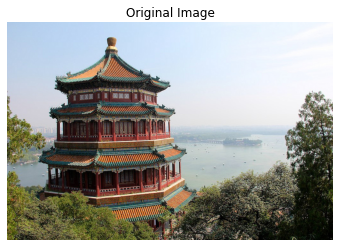

In [52]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [53]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
# then save to TFRecord

In [54]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

In [55]:
#tf.io.parse_example()를 사용하여 배치 단위로 파싱하기
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

### ﻿13.2.4 SequenceExample 프로토콜 버퍼를 사용해 리스트의 리스트 다루기

In [56]:
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};

SyntaxError: invalid syntax (<ipython-input-56-0391f63efdf6>, line 3)

In [57]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [58]:
serialized_sequence_example = sequence_example.SerializeToString()

In [59]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [60]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


## 13.3 입력 특성 전처리

Lambda 층을 사용해 표준화를 수행하는 층

In [61]:
#Lambda 층을 사용해 표준화를 수행하는 층을 구현
mean = np.maen(X_train, axis = 0, keepdims = True)
stds = np.std(X_train, axis = 0, keepdims = True)
eps = keras.backend.epsilon()
model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps))
    ...
])

SyntaxError: invalid syntax (<ipython-input-61-df85fa825365>, line 7)

In [62]:
#전역변수를 다루기보다 StandardScaler처럼 완전한 사용자 정의 층 정의
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, aixs=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [63]:
#Standardization층을 모델에 추가하기 전에 데이터 샘플과 함께 adapt()메서드를 호출
std_layer = Standardization()
std_layer.adapt(data_sample)

NameError: name 'data_sample' is not defined

### 13.3.1 원-핫 벡터를 사용해 범주형 특성 인코딩하기

In [64]:
vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

In [65]:
categories = tf.constant(['NEAR BAY', 'DESERT', 'INLAND', 'INLAND'])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1], dtype=int64)>

In [66]:
cat_one_hot = tf.one_hot(cat_indices, depth =len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

### ﻿13.3.2 임베딩을 사용해 범주형 특성 인코딩하기

In [67]:
# 임베딩 헹렬(Embedding Matrix)을 만들어 초기화
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.5749372 , 0.19900596],
       [0.7038239 , 0.05541027],
       [0.5884645 , 0.5430788 ],
       [0.9185413 , 0.37144518],
       [0.84554374, 0.9902985 ],
       [0.27800095, 0.5500362 ],
       [0.43682623, 0.68426645]], dtype=float32)>

In [68]:
#동일한 범주 특성을 인코딩
categorise = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1], dtype=int64)>

In [69]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.9185413 , 0.37144518],
       [0.27800095, 0.5500362 ],
       [0.7038239 , 0.05541027],
       [0.7038239 , 0.05541027]], dtype=float32)>

In [70]:
embedding = keras.layers.Embedding(input_dim = len(vocab) + num_oov_buckets, \
                                   output_dim = embedding_dim)
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.02671492, -0.04445466],
       [-0.03736038, -0.04224973],
       [-0.00847339, -0.04170716],
       [-0.00847339, -0.04170716]], dtype=float32)>

In [71]:
#모두 연결하면 범주형 특성을 처리하고 각 범주마다 임베딩을 학습하느 케라스 모델
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim = 6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], outputs=[outputs])

### 13.3.3 케라스 전처리 층

In [73]:
normalization = keras.layers.Normalization()
discretization = keras.layers.Discretization()
pipeline = keras.layers.PreprocessingStage([normalization, discretization])
pipeline.adapt(data_sample)

AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'PreprocessingStage'

## 13.4 TF 변환

In [74]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

TF Transform is not installed. Try running: pip3 install -U tensorflow-transform


## 13.5 텐서플로 데이터셋(TFDS) 프로젝트

In [81]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [82]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'bccd', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'd4rl_adroit_door', 'd4rl_adroit_hammer', 'd4rl_adroit_pen', 'd4rl_adroit_relocate', 'd4rl_mujoco_ant', 'd4rl_mujoco_halfcheetah', 'd4rl_mujoco_hopper', 'd4rl_mujoco_walk

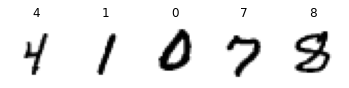

In [83]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [84]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [85]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 32.2904 - accuracy: 0.8425
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 25.4440 - accuracy: 0.8704
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 25.0263 - accuracy: 0.8721
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 24.2081 - accuracy: 0.8763
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 23.8043 - accuracy: 0.8794


In [86]:
#텐서플로 허브
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [87]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [88]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       